# Assignment 3 : Collection and Visualization

 **Subject** : Monopolistic behaviour assessment on food items in Californian prisons.

 **Authors** : Louise Gatty, Alice Pétillon, Charles Pyle, Antonio Raphael, Anne Thébaud

# 1. Research question

The core research question aims to determine whether prison-approved vendors, which hold monopoly power over commissary services, practice higher markups on basic consumer goods compared to equivalent products in conventional retail markets like Walmart. This study provides a way to assess whether the lack of competition in California's correctional facilities translates into systematically higher prices for incarcerated individuals and their families.

The analysis requires a careful matching of comparable products across disparate markets to measure the actual magnitude of price differences. It also seeks to uncover whether markups are uniform across all goods or if they vary significantly by product category.

# 2. Data description

The dataset is constructed by merging two primary sources: <br>
- Walkenhorst Data: Scraped from the Walkenhorst Family Visits Catalogue (PDF), containing food items, brands, weights in ounces, and prices. <br>
- Walmart Data: Scraped food prices and weights from Walmart’s online platform to represent a competitive retail market. <br>

NB: the scraped data originally contained many more variables and was cleaned before this analysis.

### Units and Variables:

Unit of Observation: A single matched product (e.g., a specific brand and size of sauce) found in both the Walkenhorst and Walmart catalogs.

Key Variables:
- Unit Price ($/oz): The price per ounce for both Walkenhorst and Walmart, used as the primary outcome for comparison.
- Price Difference: The calculated difference between the Walkenhorst unit price and the Walmart unit price.
- Category: The food group classification (e.g., Asian Food, Health Care Aids, Condiments).
- Match Score: A confidence score (0-100) generated using fuzzy matching to ensure the products are comparable.

Descriptive statistics are provided in part 6. Data description.

# 3. Library and data import

In [1]:
import pandas as pd
from thefuzz import fuzz, process
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.getcwd()

'/Users/Louise/Desktop/Master/M1/S2/Data_viz/Project/code'

In [2]:
# Fully scraped Walmart data
df_wallmart = pd.read_csv("../data/intermediate/Full-Products-Data/Products_Categories.csv")
df_wallmart.head()

,source_file,name,catalogProductType,price,priceInfo.linePrice,priceInfo.linePriceDisplay,priceInfo.unitPrice
0,seafood.json,"Sea Best Low Country Boil, 2 lb, Shrimp, Sausa...",Fresh & Frozen Seafood,19.36,$19.36,$19.36,60.5 ¢/oz
1,seafood.json,"Boudreaux's Frozen Cooked Peeled & Deveined, C...",Fresh & Frozen Seafood,8.96,$8.96,$8.96,74.7 ¢/oz
2,seafood.json,"Aquamar Surimi, Flake Style Fresh Imitation Cr...",Imitation Crab,2.27,$2.27,$2.27,28.4 ¢/oz
3,seafood.json,Great Value Frozen Peeled Tail on Extra Large ...,Shrimp & Prawns,6.96,$6.96,$6.96,58.0 ¢/oz
4,seafood.json,"Fresh Snow Crab Seafood Clusters Tray (1lb, 3 ...",Crab,13.77,$13.77,$13.77,86.1 ¢/oz


In [3]:
# Walkenhorst pdf scraped data
df_Walkenhorst = pd.read_csv("../data/intermediate/Scraped_Catalogue.csv")
df_Walkenhorst.head()

,Category,item,item_number,kosher,price,weight
0,ASIAN FOOD,A Taste of Thai Green Curry Paste 1.75 oz.,22668-399,False,$2.45,1.75 oz.
1,ASIAN FOOD,A Taste of Thai Pad Thai Sauce 3.25 oz.,22668-408,False,$2.95,3.25 oz.
2,ASIAN FOOD,A Taste of Thai Panang Curry Paste 1.75 oz.,22668-409,False,$2.45,1.75 oz.
3,ASIAN FOOD,A Taste of Thai Peanut Sauce Mix 3.5 oz.,22668-414,False,$2.95,3.5 oz.
4,ASIAN FOOD,A Taste of Thai Red Curry Paste 1.75 oz.,3111-998,False,$2.45,1.75 oz.


# 4. Dataframe merging

In [4]:
# Keep rows where source_file is not 'seafood.json' (we accidently have this in double)
df_wallmart = df_wallmart[df_wallmart['source_file'] != 'seafood.json']

# Removing - , / ( ) . to improve match rates 
def clean_text(text):
    if pd.isna(text): return ""
    return str(text).lower().strip().replace('-', ' ').replace('/', ' ').replace(',', ' ').replace('.', ' ').replace('(', ' ').replace(')', ' ')

df_wallmart.loc[:, 'clean_name'] = df_wallmart['name'].apply(clean_text)
df_Walkenhorst.loc[:,'clean_item'] = df_Walkenhorst['item'].apply(clean_text)

In [5]:
# Prepare the list of choices from Walkenhorst data
choices = df_Walkenhorst['clean_item'].tolist()

# Function to find the best match for a given string
def find_best_match(x):
    match, score = process.extractOne(x, choices, scorer=fuzz.token_sort_ratio) # extractOne returns (match, score, index)
    return pd.Series([match, score])

# Perform the matching
# This creates two new columns: the matched string and the confidence score
df_wallmart[['matched_item_name', 'match_score']] = df_wallmart['clean_name'].apply(find_best_match)

In [6]:
# Merge the actual data
# We merge back to df_Walkenhorst to get all the other columns
df_final = pd.merge(
    df_wallmart, 
    df_Walkenhorst, 
    left_on='matched_item_name', 
    right_on='clean_item', 
    how='left')

# We filter out low-confidence matches
df_final = df_final[df_final['match_score'] >= 70]

df_final.head()

,source_file,name,catalogProductType,price_x,priceInfo.linePrice,priceInfo.linePriceDisplay,priceInfo.unitPrice,clean_name,matched_item_name,match_score,Category,item,item_number,kosher,price_y,weight,clean_item
28,walmart_antacidtablets.json,Tums Extra Strength Heartburn Relief Chewable ...,Over-the-Counter Medicines,2.94,$2.94,$2.94,12.3 ¢/count,tums extra strength heartburn relief chewable ...,tums extra strength antacid tablets assorted f...,72,HEALTH CARE AIDS,Tums Extra Strength Antacid Tablets Assorted F...,18266-072,False,$1.25,NA oz.,tums extra strength antacid tablets assorted f...
54,walmart_antacidtablets.json,Tums Ultra Strength Antacid Tablets for Heartb...,Over-the-Counter Medicines,10.98,$10.98,$10.98,6.9 ¢/count,tums ultra strength antacid tablets for heartb...,tums regular strength antacid tablets peppermi...,75,HEALTH CARE AIDS,Tums Regular Strength Antacid Tablets Peppermi...,18266-003,True,$2.20,NA oz.,tums regular strength antacid tablets peppermi...
113,walmart_antacidtablets.json,(3 pack) Tums Ultra Strength Antacid Tablets f...,Over-the-Counter Medicines,32.94,$32.94,$32.94,6.9 ¢/count,3 pack tums ultra strength antacid tablets f...,tums regular strength antacid tablets peppermi...,71,HEALTH CARE AIDS,Tums Regular Strength Antacid Tablets Peppermi...,18266-003,True,$2.20,NA oz.,tums regular strength antacid tablets peppermi...
167,walmart_asian_food.json,"Lee Kum Kee Chili Garlic Sauce, 8 Oz",Cooking Sauces & Marinades,4.36,$4.36,$4.36,54.5 ¢/oz,lee kum kee chili garlic sauce 8 oz,lee kum kee hoisin sauce 20 oz,77,"CONDIMENTS, SAUCES & SPREADS",Lee Kum Kee Hoisin Sauce 20 oz.,90828-072,False,$3.95,20 oz.,lee kum kee hoisin sauce 20 oz
171,walmart_asian_food.json,"Kikkoman Soybean Paste With Tofu Instant Soup,...",Prepared & Packaged Soups,2.72,$2.72,$2.72,85.0 ¢/oz,kikkoman soybean paste with tofu instant soup ...,kikkoman tofu soy bean soup 1 05 oz,75,ASIAN FOOD,Kikkoman Tofu/Soy Bean Soup 1.05 oz.,3111-692,False,$4.95,1.05 oz.,kikkoman tofu soy bean soup 1 05 oz


# 5. Data cleaning

In [7]:
#Important columns selection.
df_clean = df_final[['source_file','name','price_x','priceInfo.unitPrice','item','price_y','Category','weight','match_score']].copy()

#Creating a new column for the unit price of Walkenhorst products
df_clean.loc[:, 'price_y'] = df_final['price_y'].astype(str).str.replace('$', '', regex=False)
df_clean.loc[:, 'weight'] = df_final['weight'].astype(str).str.replace(' oz.', '', regex=False)
df_clean.loc[:, 'price_y'] = pd.to_numeric(df_clean['price_y'], errors='coerce')
df_clean.loc[:, 'weight'] = pd.to_numeric(df_clean['weight'], errors='coerce')
df_clean.loc[:, 'Walkenhorst_Unit_Price'] = df_clean['price_y'] / df_clean['weight']

#Put the same unit for all unit prices of walkenhorset products ($/oz)
def clean_unit_price(value):
    val_str = str(value).lower()
    
    if '¢' in val_str:
        clean_val = pd.to_numeric(val_str.replace('¢/oz', '').strip(), errors='coerce')
        return clean_val / 100 
    
    elif '$' in val_str:
        clean_val = pd.to_numeric(val_str.replace('$/oz', '').replace('$', '').strip(), errors='coerce')
        return clean_val
    
    return pd.to_numeric(val_str, errors='coerce')

df_clean.loc[:, 'priceInfo.unitPrice'] = df_final['priceInfo.unitPrice'].apply(clean_unit_price)


#Changing the names of the columns
df_clean = df_clean.rename(columns={
    'price_x': 'Walmart_Price ($)',
    'priceInfo.unitPrice': 'Walmart_Unit_Price ($/oz)',
    'price_y': 'Walkenhorst_Price ($)',
    'name' : 'Name_Walmart',
    'item' : 'Name_Walkenhorst',
    'weight' : 'Walkenhorst_Weight (oz)',
    'Walkenhorst_Unit_Price' : 'Walkenhorst_Unit_Price ($/oz)'})

df_clean
df_clean.to_csv('../data/processed/Walmart_Walkenhorst_data.csv', index=False)

# 6. Data description

## 6.1. Distribution of price differences

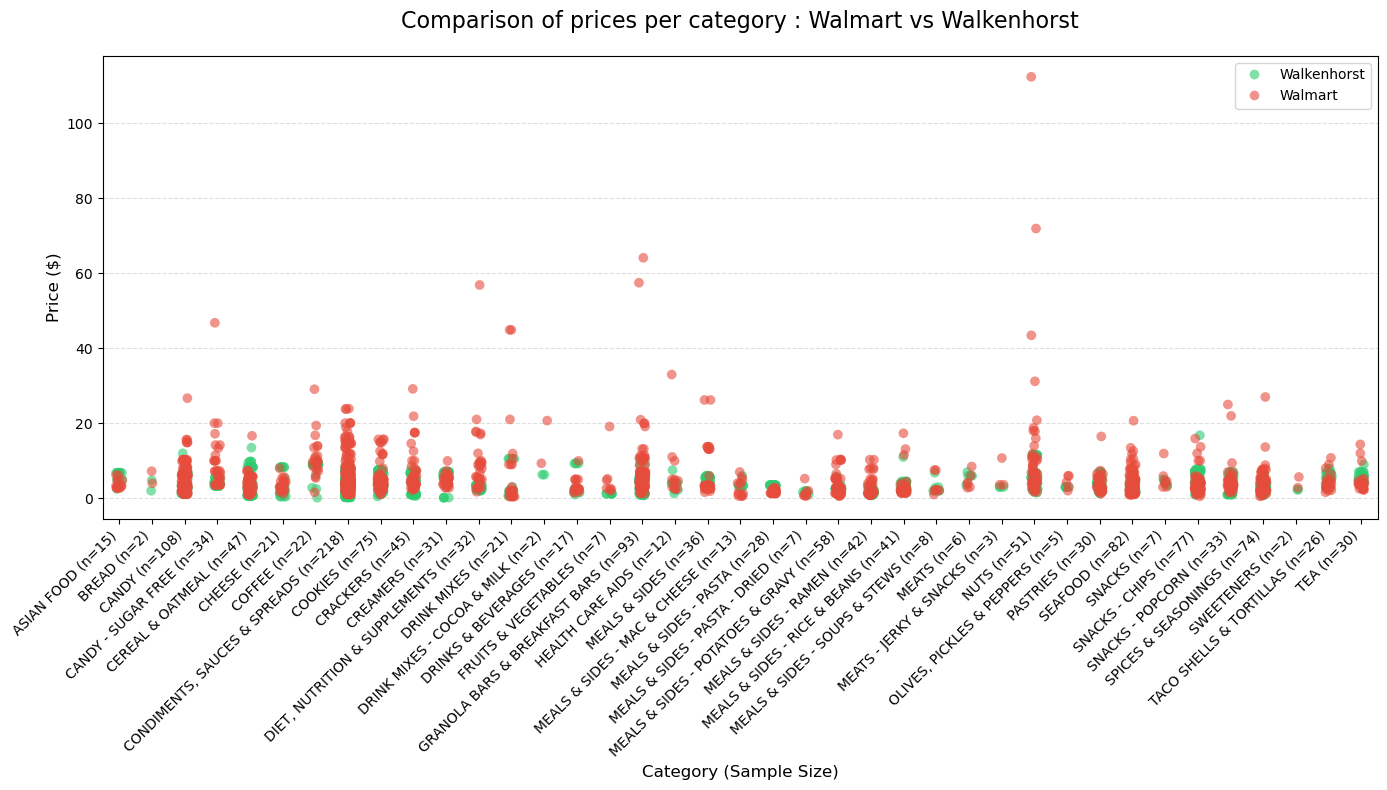

In [8]:
# Creating a plot comparing overall prices per category 

def generate_price_plot(df):
    counts = df['Category'].value_counts()
    category_mapping = {cat: f"{cat} (n={count})" for cat, count in counts.items()}
    df['Category_Label'] = df['Category'].map(category_mapping)

    df_plot = df.melt(
        id_vars=['Category_Label'], 
        value_vars=['Walkenhorst_Price ($)', 'Walmart_Price ($)'], 
        var_name='Store', 
        value_name='Price')

    df_plot['Store'] = df_plot['Store'].replace({
        'Walkenhorst_Price ($)': 'Walkenhorst', 
        'Walmart_Price ($)': 'Walmart'})
    
    plt.figure(figsize=(14, 8))
    
    sns.stripplot(
        data=df_plot, 
        x='Category_Label', 
        y='Price', 
        hue='Store', 
        jitter=True,      
        alpha=0.6,        
        palette={'Walkenhorst': '#2ecc71', 'Walmart': '#e74c3c'},
        size=7,
        order=sorted(df['Category_Label'].unique()))
    
    plt.title('Comparison of prices per category : Walmart vs Walkenhorst', fontsize=16, pad=20)
    plt.xlabel('Category (Sample Size)', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.xticks(rotation=45, ha='right') 
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend(title='')
    plt.tight_layout()
    plt.show()

generate_price_plot(df_clean)

#We see that this does not work well with df_clean because of the large number of categories with few products each. Also, some categories have extreme price values that skew the visualization. 
# But most importantly, walmart prices seem to be higher - this could result from the fact that we are comparing different products for each categories.

This grouped bar chart compares the average nominal retail price (the sticker price in dollars) between Walkenhorst and Walmart across several product categories, such as "Asian Food," "Condiments," and "Health Care Aids." This represents the immediate out-of-pocket cost for a consumer per item, regardless of the package size.

This chart is not easily readable thus we provide another one with the price/ounce.

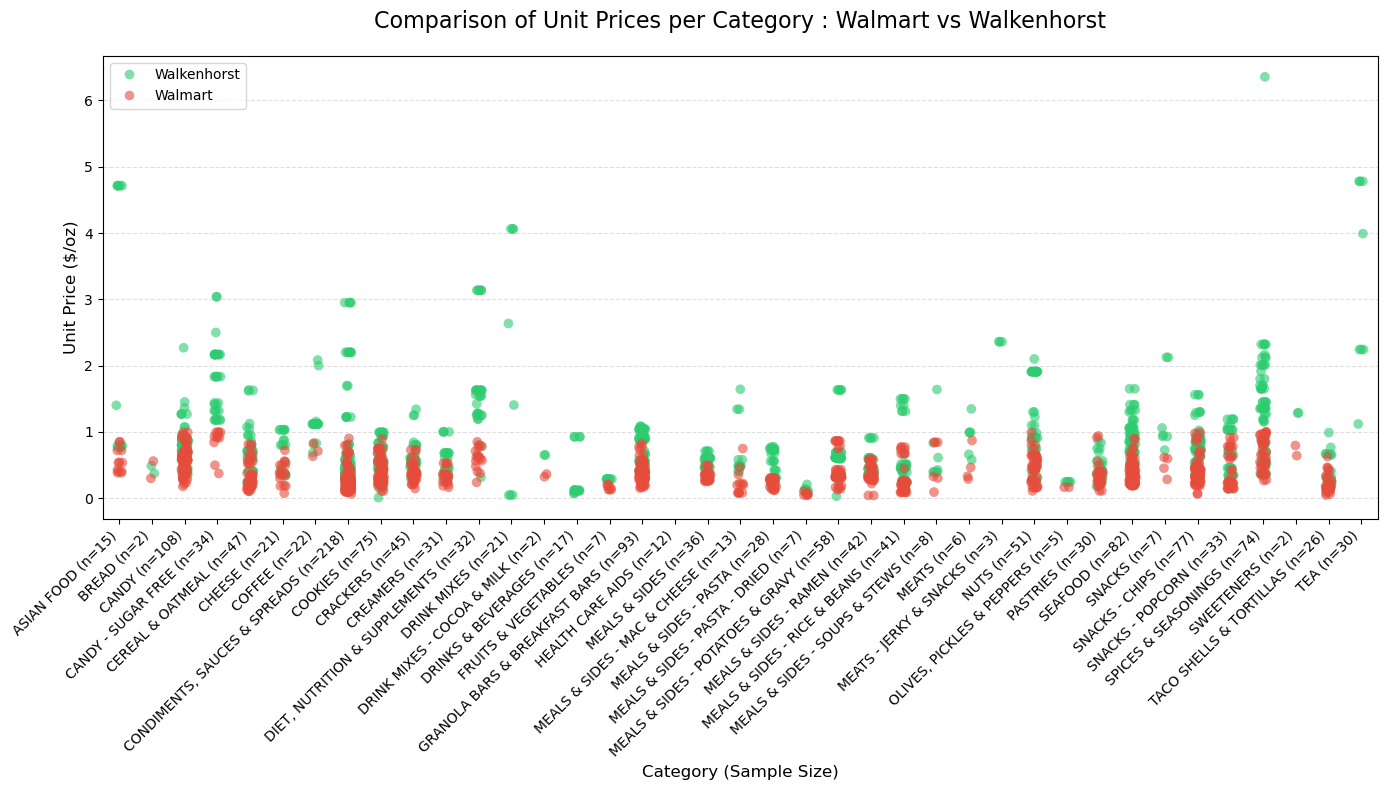

In [9]:
# Creating a plot comparing overall prices/ounce per category 

def generate_price_plot(df):
    counts = df['Category'].value_counts()
    category_mapping = {cat: f"{cat} (n={count})" for cat, count in counts.items()}
    df['Category_Label'] = df['Category'].map(category_mapping)

    df_plot = df.melt(
        id_vars=['Category_Label'], 
        value_vars=['Walkenhorst_Unit_Price ($/oz)', 'Walmart_Unit_Price ($/oz)'], 
        var_name='Store', 
        value_name='Unit price')

    df_plot['Store'] = df_plot['Store'].replace({
        'Walkenhorst_Unit_Price ($/oz)': 'Walkenhorst', 
        'Walmart_Unit_Price ($/oz)': 'Walmart'})
    
    plt.figure(figsize=(14, 8))
    
    sns.stripplot(
        data=df_plot, 
        x='Category_Label', 
        y='Unit price', 
        hue='Store', 
        jitter=True,      
        alpha=0.6,        
        palette={'Walkenhorst': '#2ecc71', 'Walmart': '#e74c3c'},
        size=7,
        order=sorted(df['Category_Label'].unique()))
    
    plt.title('Comparison of Unit Prices per Category : Walmart vs Walkenhorst', fontsize=16, pad=20)
    plt.xlabel('Category (Sample Size)', fontsize=12)
    plt.ylabel('Unit Price ($/oz)', fontsize=12)
    plt.xticks(rotation=45, ha='right') 
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend(title='')
    plt.tight_layout()
    plt.show()

generate_price_plot(df_clean)

This chart compares the average price per ounce (unit price) for both vendors.

This is the core evidence of the study. Even after normalizing for weight, Walkenhorst's prices per ounce remain systematically higher than Walmart's across all categories. The gap is particularly stark in categories like "Condiments, Sauces & Spreads," where the Walkenhorst price per ounce is significantly higher. This proves that the price difference is not due to larger package sizes provided by the prison vendor, but rather a significantly higher markup. This result confirms the research hypothesis: the monopolistic vendor leverages its exclusive access to the carceral market to charge prices well above competitive retail rates.

## 6.2. Price differences between Walmart and Walkenhorst

--- Statistics of the price differences (%) ---
Moyenne : 21.26%
Médiane : 0.18%
Minimum : -99.16% (Walmart beaucoup moins cher)
Maximum : 875.00% (Walmart beaucoup plus cher)
--------------------------------------------------


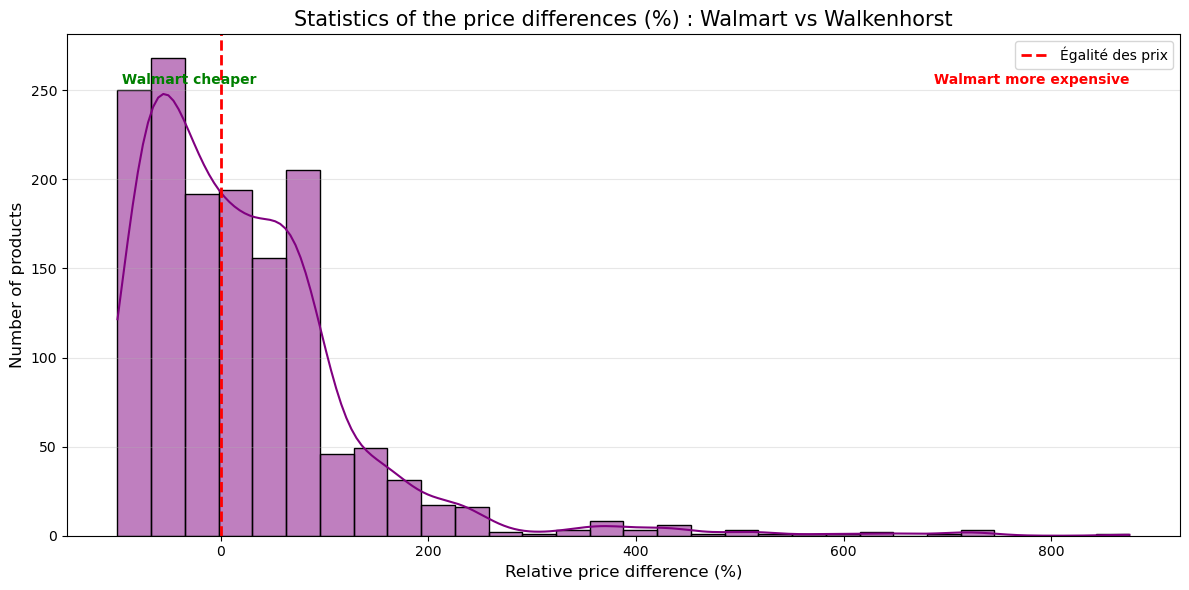

In [13]:
#Comparing similar products : price difference

def analyze_price_differences(df):
    df['price_diff'] = df['Walkenhorst_Price ($)'] - df['Walmart_Price ($)']
    df['price_diff_pct'] = (df['price_diff'] / df['Walmart_Price ($)']) * 100
    df_clean['price_diff_pct'] = pd.to_numeric(df_clean['price_diff_pct'], errors='coerce')

    # Summary statistics
    stats = df['price_diff_pct'].describe()
    print("--- Statistics of the price differences (%) ---")
    print(f"Moyenne : {stats.loc['mean']:.2f}%")
    print(f"Médiane : {stats.loc['50%']:.2f}%")
    print(f"Minimum : {stats.loc['min']:.2f}% (Walmart beaucoup moins cher)")
    print(f"Maximum : {stats.loc['max']:.2f}% (Walmart beaucoup plus cher)")
    print("--------------------------------------------------")

    # Histogramm of the distribution of price differences
    plt.figure(figsize=(12, 6))
    sns.histplot(df['price_diff_pct'], kde=True, color='purple', bins=30)
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Égalité des prix')
    
    # Annotations
    plt.text(stats.loc['min'], plt.ylim()[1]*0.9, ' Walmart cheaper', color='green', fontweight='bold')
    plt.text(stats.loc['max'], plt.ylim()[1]*0.9, ' Walmart more expensive', color='red', fontweight='bold', ha='right')

    plt.title('Statistics of the price differences (%) : Walmart vs Walkenhorst', fontsize=15)
    plt.xlabel('Relative price difference (%)', fontsize=12)
    plt.ylabel('Number of products', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_price_differences(df_clean)

Description: This boxplot displays the distribution of the variable Unit_Price_Diff (calculated as Walkenhorst Unit Price minus Walmart Unit Price) across all matched products. The red dashed line represents the point of price parity (0.00). We have excluded outliers to focus on the interquartile range (the middle 50% of the data).

Interpretation: The entire box and the median line are positioned significantly above the zero-parity line. This indicates a systematic "monopoly premium." Because the median is positive, we can conclude that for the vast majority of items, Walkenhorst is more expensive per ounce. The height of the box shows that while some items have a modest markup of around $0.10 per ounce, others reach markups exceeding $0.25 per ounce, representing a substantial additional financial burden on incarcerated individuals.

## 6.3. Markups

<Figure size 640x480 with 0 Axes>

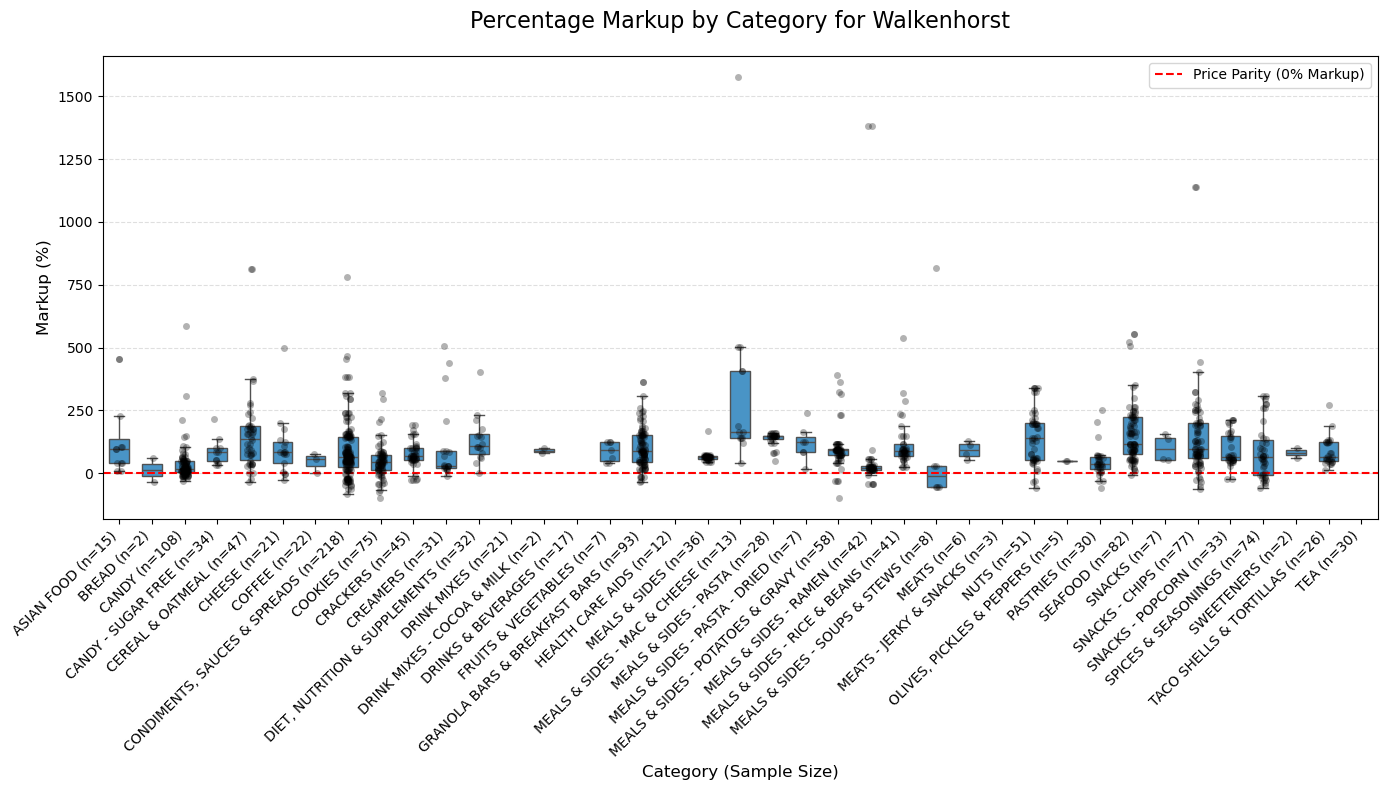

In [17]:
def generate_markup_plot_by_category(df):
    # 1. Create a copy and calculate the markup percentage per item
    df_plot = df.copy()
    df_plot['Markup_Pct'] = (
        (df_plot['Walkenhorst_Unit_Price ($/oz)'] - df_plot['Walmart_Unit_Price ($/oz)']) / 
        df_plot['Walmart_Unit_Price ($/oz)']
    ) * 100

    # 2. Generate Category Labels with sample sizes (n=x)
    plt.subplots_adjust(bottom=0.7)
    counts = df_plot['Category'].value_counts()
    category_mapping = {cat: f"{cat} (n={count})" for cat, count in counts.items()}
    df_plot['Category_Label'] = df_plot['Category'].map(category_mapping)
    
    # Sort categories alphabetically for a consistent x-axis
    plot_order = sorted(df_plot['Category_Label'].unique())

    # 3. Plotting
    plt.figure(figsize=(14, 8))
    
    # Boxplot shows the distribution of markups per category
    sns.boxplot(
        data=df_plot, 
        x='Category_Label', 
        y='Markup_Pct', 
        order=plot_order,
        color='#3498db', 
        width=0.6,
        showfliers=False  # Removes extreme outliers to keep the scale readable
    )
    
    # Adding a stripplot on top allows us to see individual data points
    sns.stripplot(
        data=df_plot, 
        x='Category_Label', 
        y='Markup_Pct', 
        order=plot_order,
        color='black', 
        alpha=0.3, 
        jitter=True
    )

    # 4. Formatting
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Price Parity (0% Markup)')
    plt.title('Percentage Markup by Category for Walkenhorst', fontsize=16, pad=20)
    plt.xlabel('Category (Sample Size)', fontsize=12)
    plt.ylabel('Markup (%)', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Execute the function
generate_markup_plot_by_category(df_clean)

Markup Calculation: $\frac{Walkenhorst\ unit\ price - Walmart\ unit\ price}{Walmart\ unit\ price} \times 100$. <br>
This percentage indicates how much more expensive an item is at Walkenhorst compared to Walmart, relative to the Walmart base price.

This boxplot illustrates the distribution of the difference in unit prices ($/oz) between Walkenhorst and Walmart. The red dashed line at zero represents "Price Parity" (where prices would be identical). Outliers have been excluded to better visualize the concentration of the main data points.
The visualization clearly shows that the entire "box" (representing the middle 50% of the products) and the median line are situated well above the zero-line. This indicates a systematic "monopoly premium." For the vast majority of products in our sample, Walkenhorst charges a higher price per ounce than Walmart. The fact that even the lower whisker sits near or above zero suggests that it is rare for the prison vendor to offer prices lower than or even equal to the competitive market, confirming the presence of significant markups across the catalogue.

# 7. Limits

While our preliminary analysis reveals a clear price disparity, we have identified several limitations that affect the precision of our results. We plan to address these in the final stages of the project:

**1. Data Attrition and Merging Efficiency** <br>
Our current fuzzy merging process resulted in a significant loss of data, reducing our sample from approximately 4,000 potential matches to 1,500 high-confidence observations.

*Future Step:* We aim to improve the "hit rate" by performing more aggressive data cleaning—specifically removing numeric strings and non-essential descriptors—and iterating the matching process category-by-category to ensure a more robust dataset.

**2. Sample Size per Category** <br>
Certain specific categories currently contain too few observations to be statistically representative.

*Future Step:* We will group related sub-categories (for example, merging various "Snack" and "Candy" labels into a single aggregate category) to increase the number of data points per group and improve the reliability of our visualizations.

**3. Unit Measurement Inconsistencies** <br>
The comparison currently relies primarily on price-per-ounce. However, for certain items like medical supplies or pre-packaged individual items, a "price-per-count" is more appropriate.

*Future Step:* We are developing a specific function to handle "count-based" items separately from "weight-based" items to avoid excluding non-food essentials from the study.

**4. The "Economies of Scale" Bias** <br>
A significant limitation is that Walmart often sells products in large bulk packs, whereas Walkenhorst tends to sell smaller individual portions. Even when comparing price-per-ounce, this does not account for the natural "economy of scale" price reduction found in larger retail packages.

*Future Step:* We are considering adding a weighting or normalization factor to account for package size differences to ensure the markup we identify is due to monopoly power and not simply the result of comparing bulk vs. individual pricing.

**5. Lack of Qualitative Control Variables** <br> We currently lack detailed nutritional information or ingredient quality data. Without these variables to act as controls, we cannot perform a formal regression analysis to isolate the "monopoly effect" from potential quality differences.

**6. Outlier Sensitivity** <br> Our initial boxplots show significant variance.

*Future Step:* We will conduct a thorough review of the top and bottom 5% of our price differences to determine if these represent true market anomalies or data scraping errors that should be removed.

**7. "Basket of Goods" Analysis** To provide a more concrete conclusion for policy recommendations, we intend to simulate a "typical monthly basket" for an incarcerated individual. This will allow us to calculate a total percentage markup for a realistic set of purchases, making the economic impact on families more tangible.